In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [2]:
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

In [3]:
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.2,    
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    class_mode='categorical',
    batch_size=64
)


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
base_model = tf.keras.applications.DenseNet121(input_shape=(48,48,3),include_top=False,weights="imagenet")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Freezing Layers

In [7]:
# Building Model

model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.2),  # Lowered dropout
    Dense(128, activation='relu'),
    Dropout(0.2),  # Lowered dropout
    Dense(64, activation='relu'),
    Dropout(0.2),  # Lowered dropout
    Dense(7, activation='softmax')
])

In [8]:
# Model Summary

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
#Compliling the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the callbacks
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=4, 
    verbose=1, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=3, 
    verbose=1, 
    min_delta=0.0001
)


# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, earlystop, reduce_lr]  # Add all callbacks here
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731186506.169149      87 service.cc:145] XLA service 0x783dfc0037b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731186506.169204      87 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1731186579.823331      87 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_concatenate_fusion_75', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_715', 4 bytes spill stores, 4 bytes spill loa

103/359 ━━━━━━━━━━━━━━━━━━━━ 1:21 317ms/step - accuracy: 0.1390 - loss: 2.1859

I0000 00:00:1731186681.719074      89 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_712', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_711', 4 bytes spill stores, 4 bytes spill loads



359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.1898 - loss: 2.0224
Epoch 1: val_accuracy improved from -inf to 0.30395, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 356s 614ms/step - accuracy: 0.1899 - loss: 2.0221 - val_accuracy: 0.3040 - val_loss: 1.7280 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3156 - loss: 1.7180
Epoch 2: val_accuracy improved from 0.30395 to 0.38739, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 146ms/step - accuracy: 0.3156 - loss: 1.7179 - val_accuracy: 0.3874 - val_loss: 1.5842 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.3789 - loss: 1.5925
Epoch 3: val_accuracy improved from 0.38739 to 0.44504, saving model to model_weights.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 135ms/step - accuracy: 0.3789 - loss: 1.5924 - val_accuracy: 0.4450 - val_loss: 1.4534 - learning_rate: 1.0000e-04
Epoch 4/50
359

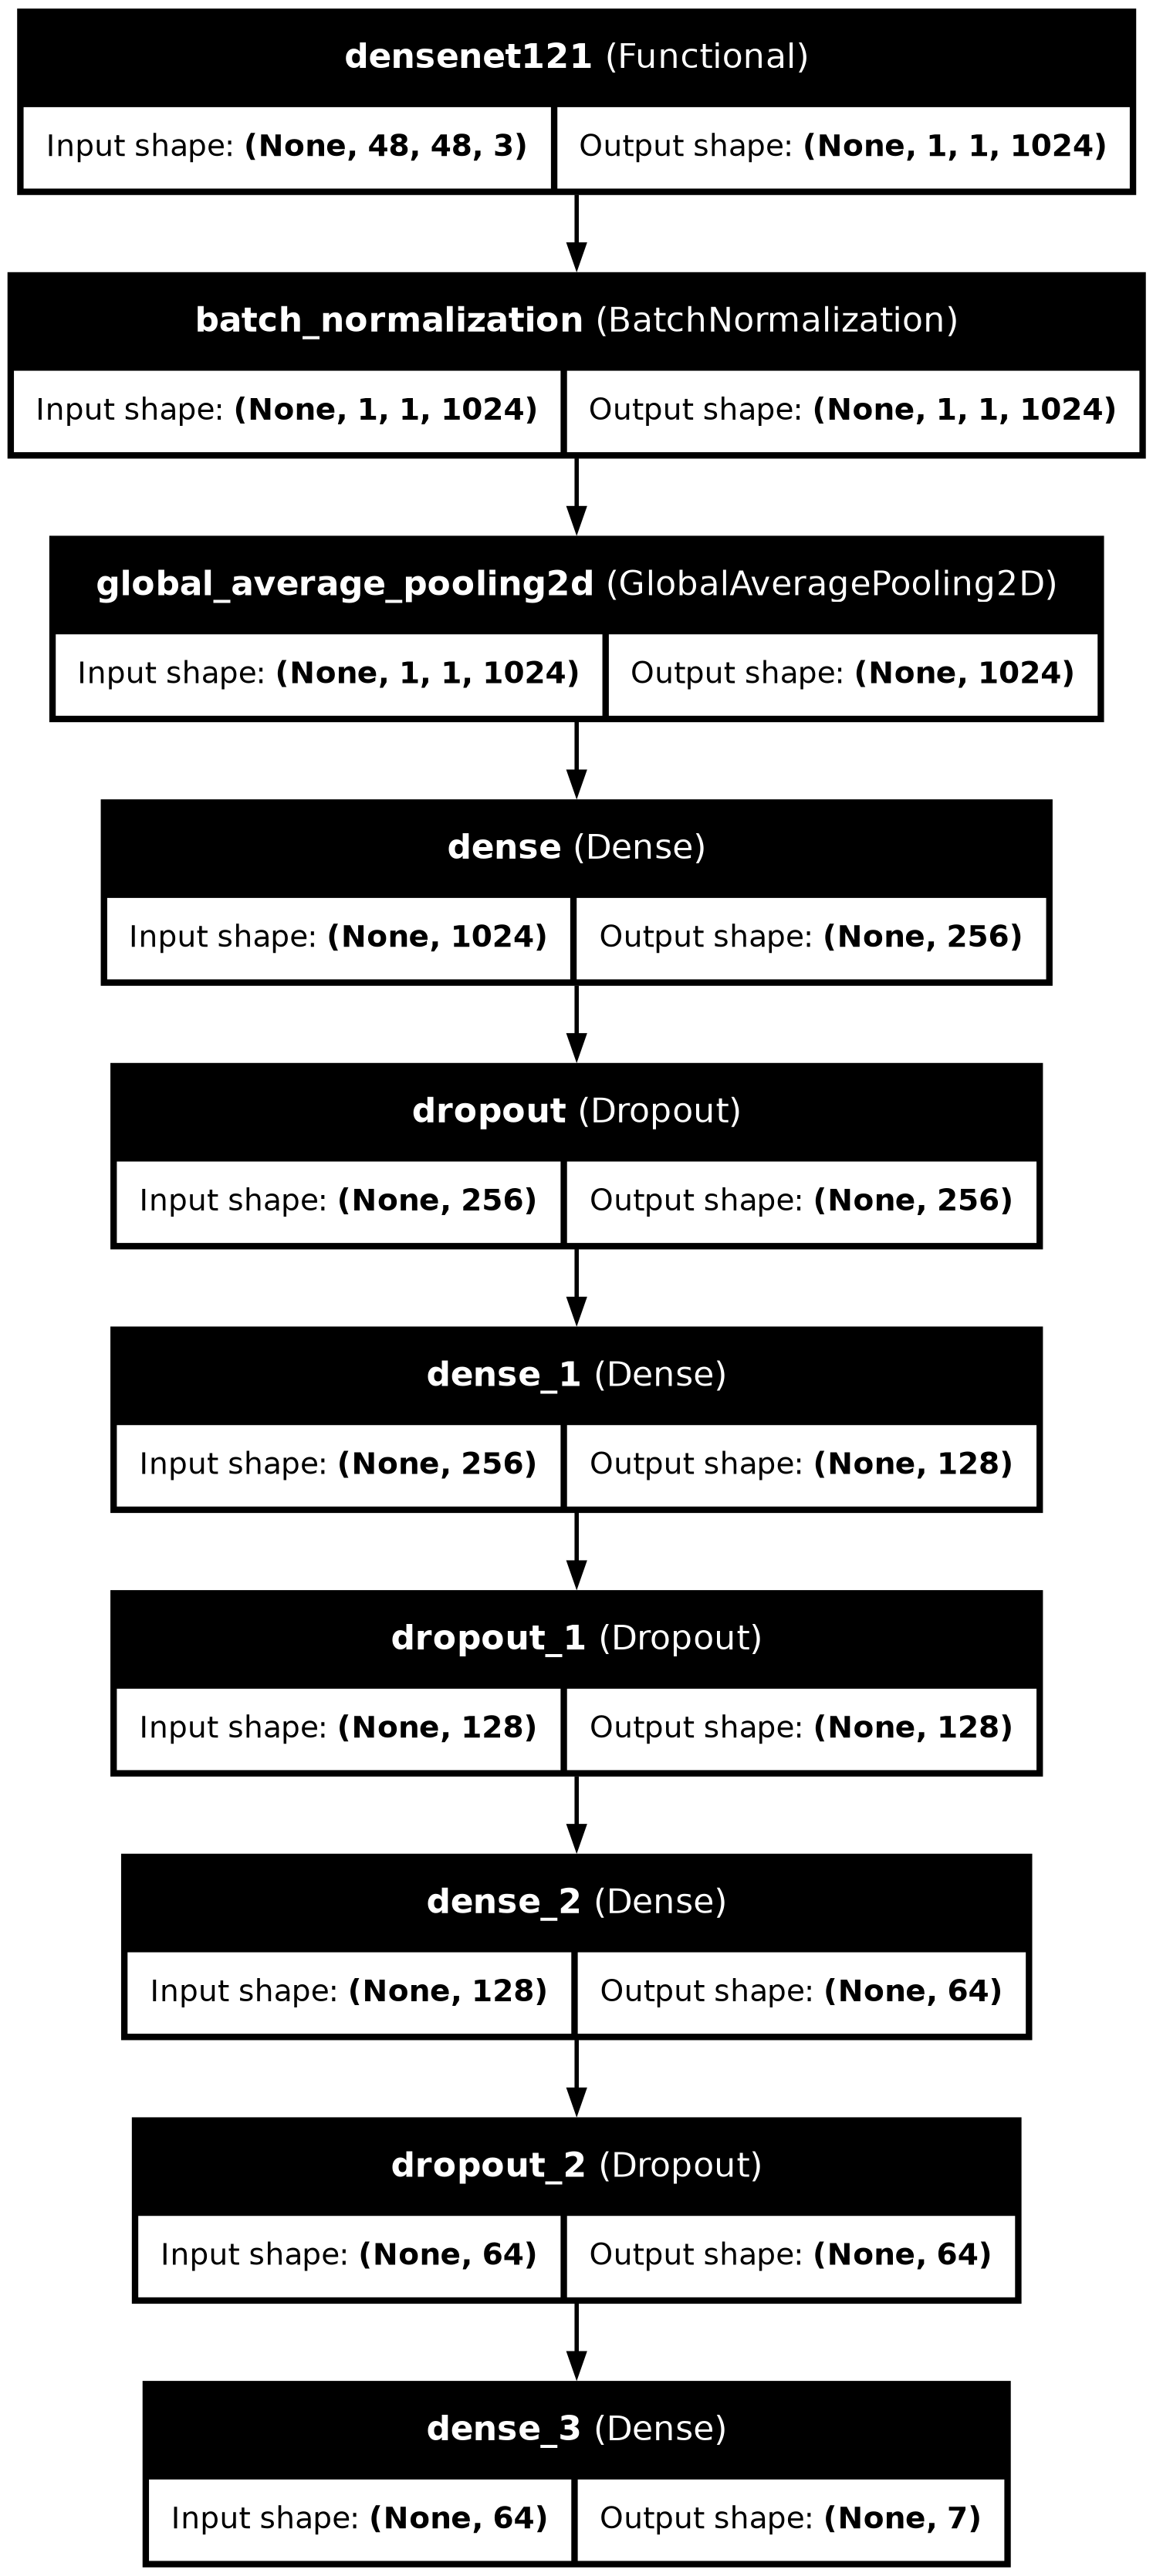

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [12]:
# Modell kiértékelése a teszt adatokon
model.load_weights(filepath='/kaggle/working/model_weights.weights.h5')
evaluation = model.evaluate(test_generator, verbose=1)
print('Test Loss:', evaluation[0])
print('Test Accuracy:', evaluation[1])

  2/113 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.5781 - loss: 1.0372 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 363ms/step - accuracy: 0.6135 - loss: 1.0208
Test Loss: 1.0166853666305542
Test Accuracy: 0.6199498176574707


In [13]:
model.save('model.h5')

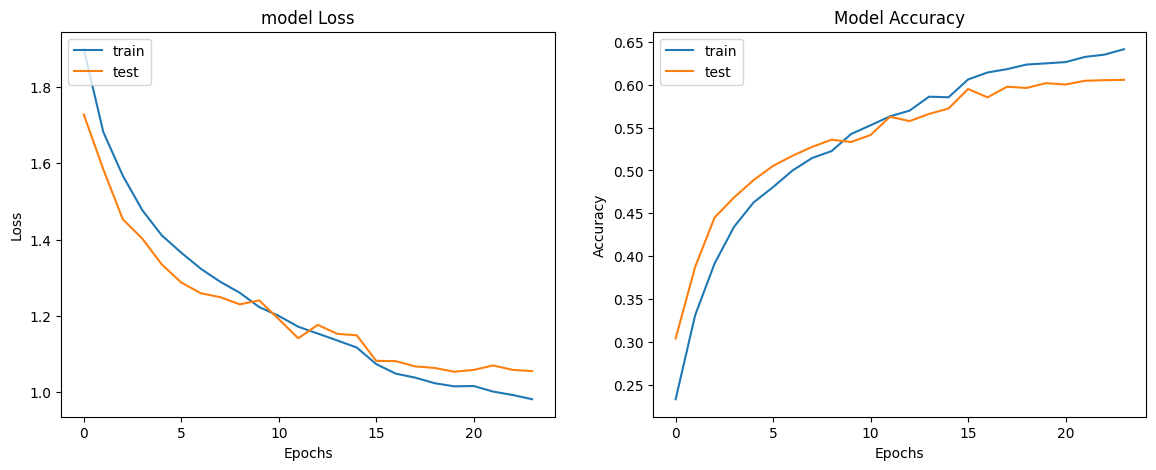

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

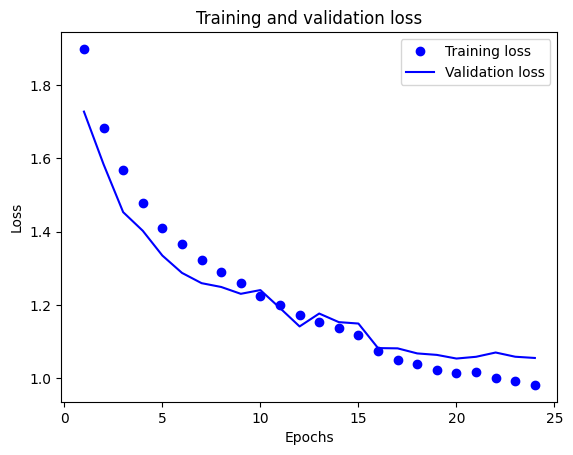

In [15]:
# Plot the train and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

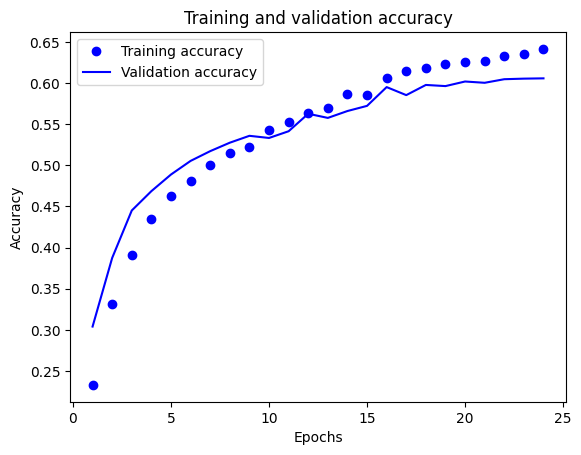

In [16]:
# Plot the train and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 223ms/step


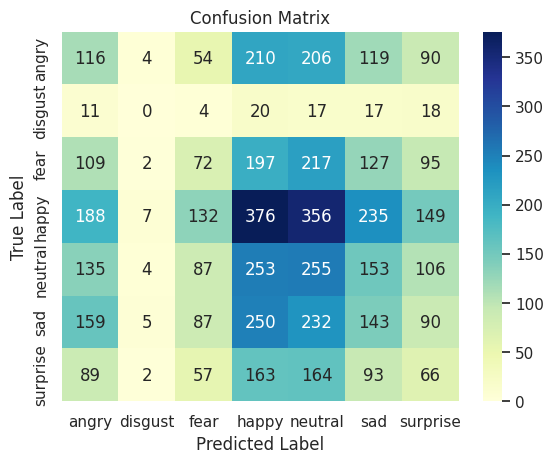

In [17]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the validation set
validation_labels = val_generator.classes
validation_pred_probs = model.predict(val_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(train_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()